In [8]:
%pylab inline
from siph import *


import h5py
import condor

Populating the interactive namespace from numpy and matplotlib


/Users/hantke/Library/Python/2.7/lib/python/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['histogram']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [9]:
wl_O_Kalpha = 2.362E-9
wl_N_Kalpha = 3.16E-9
wl_C_Kalpha = 4.47E-9
EeV_O_Kalpha = condor.source.Photon(wavelength=wl_O_Kalpha).get_energy_eV()
EeV_N_Kalpha = condor.source.Photon(wavelength=wl_N_Kalpha).get_energy_eV()
EeV_C_Kalpha = condor.source.Photon(wavelength=wl_C_Kalpha).get_energy_eV()
EeV_photon = np.median(photon_energies_SLAC)
photon_energyO = EeV_O_Kalpha/EeV_photon
photon_energyN = EeV_N_Kalpha/EeV_photon
photon_energyC = EeV_C_Kalpha/EeV_photon

In [10]:
def read_data(experiment, run_number, N=10, skip=1):
    filename = "/Users/hantke/davinci/scratch/fhgfs/xray/%s/preproc/%s_r%04i_ol3.h5" % (experiment,experiment,run_number)
    with h5py.File(filename, "r") as f:
        imgs = asarray(f["entry_1/data_1/data"][-N-skip:-skip])
        msk = asarray(f["entry_1/data_1/mask"])
        gains = asarray(f["entry_1/detector_1/gain"][-N-skip:-skip])
        photon_energies_SLAC = asarray(f["entry_1/FEL/photon_energy_eV_SLAC"][-N-skip:-skip])
        gmds = asarray(f["entry_1/detector_3/pulse_energy_mJ"][-N-skip:-skip])
    return imgs, msk, gains, photon_energies_SLAC, gmds

def apply_mask(imgs, msk, rlims=None):
    tmp = asarray([(msk&condor.utils.pixelmask.PixelMask.PIXEL_IS_IN_MASK)==0])
    #tmp[:,:512] = False
    if rlims is not None:
        X, Y = meshgrid(arange(msk.shape[1]), arange(msk.shape[0]))
        R = sqrt((X-msk.shape[1]/2.)**2 + (Y-msk.shape[0]/2.)**2)
        tmp *= asarray([(R >= rlims[0])*(R <= rlims[1])])
    tmp = repeat(tmp, imgs.shape[0], axis=0)
    values = imgs.flatten()[tmp.flatten()]
    return values
    

(0, 10000)

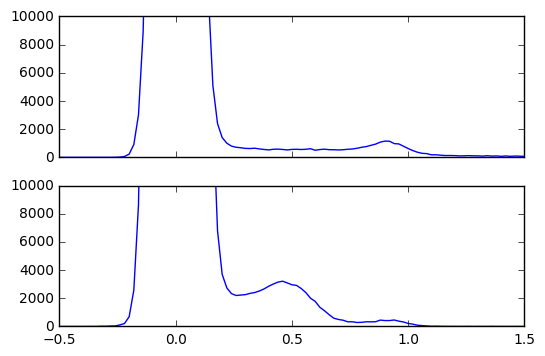

In [76]:
nbins = 101
ex = "amol3416"
N = 10

fig, axs = subplots(2, 1, sharey=True, sharex=True)

# No gas
r = 154
imgs, msk, gains, photon_energies_SLAC, gmds = read_data(ex, r, N, skip=2000)
values = apply_mask(imgs, msk, rlims=(50, 300))
photons = values / gains.mean()
I_no, H_no = histogram(photons, nbins=nbins)
axs[0].plot(I_no, H_no)

# Only N2
r = 152
imgs, msk, gains, photon_energies_SLAC, gmds = read_data(ex, r, N, skip=2000)
values = apply_mask(imgs, msk, rlims=(250, 2000))
photons = values / gains.mean()
I_N2, H_N2 = histogram(photons, nbins=nbins)
axs[1].plot(I_N2, H_N2)

#from python_tools import gentools 
#[A0, x0, sigma], Hest = gentools.gaussian_fit(I, H)
#print "A0", A0
#print "x0", x0
#print "sigma", sigma
#print I.shape,H.shape

ylim(0, 10000)

0.152528987382 11.5567526266 2503652 0.049613070909

(0.0, 10000)

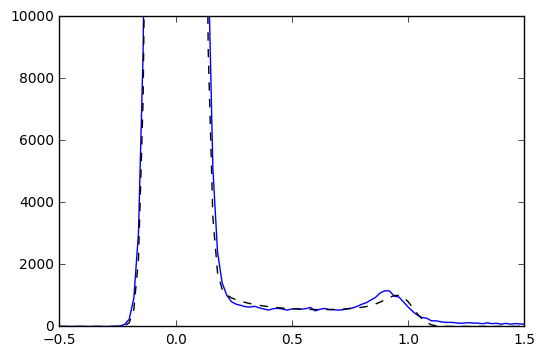

In [99]:
#sigma0 = 0.25
#L0 = 10
#noise_sigma0 = 0.2
sigma0 = 0.17
L0 = 20
noise_sigma0 = 0.05
sigma_fit, L_fit, nphotons_fit, noise_sigma_fit = fit_hist2(H_no, sigma=sigma0, L=L0, 
                                                         noise_sigma=noise_sigma0)
I_1_fit, H_1_fit = hist_I(sigma_fit, L_fit, nphotons_fit, noise_sigma=noise_sigma_fit, nbins=nbins)

print sigma_fit, L_fit, nphotons_fit, noise_sigma_fit,
plot(I_no, H_no)
plot(I_1_fit, H_1_fit, "--", color="black")
ylim(None, 10000)

In [100]:
hist_I_1 = lambda L, nphotons: hist_I(sigma_fit, L, nphotons, noise_sigma=noise_sigma_fit,
                                      nbins=nbins, photon_energy=1.0)[1]



hist_I_N = lambda L, nphotons: hist_I(sigma_fit, L, nphotons, noise_sigma=noise_sigma_fit,
                                      nbins=nbins, photon_energy=photon_energyN)[1]
#hist_I_C = lambda L, nphotons: hist_I(sigma_fit, L, nphotons, noise_sigma=noise_sigma_fit,
#                                             nbins=nbins, photon_energy=photon_energyC)[1]
#hist_I_O = lambda L, nphotons: hist_I(sigma_fit, L, nphotons, noise_sigma=noise_sigma_fit,
#                                             nbins=nbins, photon_energy=photon_energyO)[1]
#H_sum = lambda L, nphotons1, nphotonsN, nphotonsC, nphotonsO: hist_I_1(abs(L), abs(nphotons1)) +\
#                                                              hist_I_N(abs(L), abs(nphotonsN)) +\
#                                                              hist_I_C(abs(L), abs(nphotonsC)) +\
#                                                              hist_I_O(abs(L), abs(nphotonsO))
H_sum = lambda L, nphotons1, nphotonsN: hist_I_1(abs(L), abs(nphotons1)) +\
                                        hist_I_N(abs(L), abs(nphotonsN))
func = lambda x: (H_N2 - H_sum(x[0], x[1], x[2]))/(H_N2 + H_sum(x[0], x[1], x[2]))
x = scipy.optimize.leastsq(func, [L_fit, 10000., 10000.])[0]
x = abs(array(x))
[L_fit2, nphotons1_fit, nphotonsN_fit] = x
print x


[  1.40696603e+01   2.12271723e+06   7.93392696e+06]


(0, 10000)

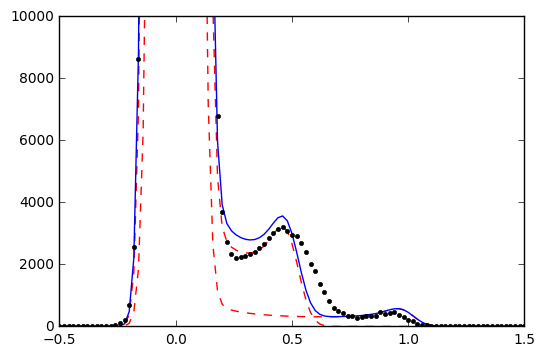

In [101]:
I = linspace(-0.5, 1.5, nbins)
H_1 = hist_I_1(L_fit2, nphotons1_fit)
H_N = hist_I_N(L_fit2, nphotonsN_fit)
#H_C = hist_I_C(L_fit2, nphotonsC_fit)
#H_O = hist_I_O(L_fit2, nphotonsO_fit)

I = linspace(-0.5, 1.5, nbins)
plot(I, H_1, "--", c='red')
plot(I, H_N, "--", c='red')
#plot(I, H_C, "--", c='red')
#plot(I, H_O, "--", c='red')
#plot(I, H_1+H_N+H_C+H_O)
plot(I, H_1+H_N)
plot(I, H_N2, ".", c="black")
ylim(0, 10000)

In [102]:
print L_fit2, sigma_fit, nphotons1_fit
print L_fit2, sigma_fit, nphotonsN_fit

14.0696602774 0.152528987382 2122717.22657
14.0696602774 0.152528987382 7933926.95503


In [103]:
I1_test, H1_test = generate_test_hist_I(sigma=sigma_fit, L=L_fit2, nphotons=int(nphotons1_fit), 
                                        noise_sigma=noise_sigma_fit, nbins=nbins, photon_energy=1.0)
IN_test, HN_test = generate_test_hist_I(sigma=sigma_fit, L=L_fit2, nphotons=int(nphotonsN_fit),
                                        noise_sigma=noise_sigma_fit, nbins=nbins, photon_energy=photon_energyN)


(0, 10000)

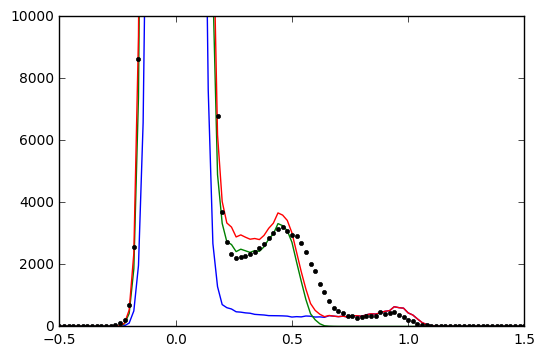

In [104]:
plot(I1_test, H1_test)
plot(IN_test, HN_test)
plot(IN_test, H1_test + HN_test)
plot(I, H_N2, ".", c="black")
ylim(0, 10000)

(0, 10000)

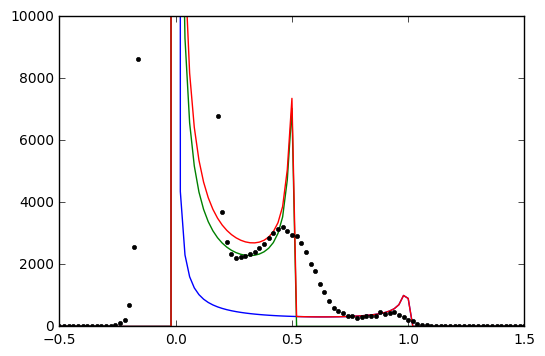

In [105]:
I1_ideal, H1_ideal = hist_I(sigma_fit, L_fit2, int(nphotons1_fit), noise_sigma=None, nbins=nbins, photon_energy=1.0)
IN_ideal, HN_ideal = hist_I(sigma_fit, L_fit2, int(nphotonsN_fit), noise_sigma=None, nbins=nbins, photon_energy=photon_energyN)
plot(I1_ideal, H1_ideal)
plot(IN_ideal, HN_ideal)
plot(IN_ideal, H1_ideal + HN_ideal)
plot(I, H_N2, ".", c="black")
ylim(0, 10000)